# Getting and preparing the data



This is a modified notebook from the original fairlearn package notebook on postprocessing. This works for both Compas and Adult.

In [1]:
import pandas as pd
import numpy as np

dataset_used = 'compas'

if(dataset_used == 'compas'):
    compas_train = pd.read_csv('./../../data/compas_train.csv')
    compas_val = pd.read_csv('./../../data/compas_val.csv')
    compas_test = pd.read_csv('./../../data/compas_test.csv')

    y_train = compas_train.pop('two_year_recid') 
    y_test = compas_test.pop('two_year_recid')
    sensitive_features_train = compas_train['race'] 
    sensitive_features_test = compas_test['race']
    X_train = compas_train
    X_test = compas_test
    
    sensitive_features_train = sensitive_features_train.replace(0, 'African-American')
    sensitive_features_train = sensitive_features_train.replace(1, 'Caucasian')
    sensitive_features_test = sensitive_features_test.replace(0, 'African-American')
    sensitive_features_test = sensitive_features_test.replace(1, 'Caucasian')
    
elif(dataset_used == 'adult'):
    adult_train = pd.read_csv('./../../data/adult_train.csv')
    adult_val = pd.read_csv('./../../data/adult_val.csv')
    adult_test = pd.read_csv('./../../data/adult_test.csv')

    y_train = adult_train.pop('Income Binary') 
    y_test = adult_test.pop('Income Binary')
    sensitive_features_train = adult_train['sex']
    sensitive_features_test = adult_test['sex']
    X_train = adult_train
    X_test = adult_test
    
    sensitive_features_train = sensitive_features_train.replace(0, 'Female')
    sensitive_features_train = sensitive_features_train.replace(1, 'Male')
    sensitive_features_test = sensitive_features_test.replace(0, 'Female')
    sensitive_features_test = sensitive_features_test.replace(1, 'Male')
    
else:
    print('Invalid dataset_used variable.')

In [2]:
X_train.loc[0], y_train[0]

(Unnamed: 0                  7796.0
 sex                            0.0
 race                           0.0
 age_cat=25 to 45               1.0
 age_cat=Greater than 45        0.0
 age_cat=Less than 25           0.0
 priors_count=0                 0.0
 priors_count=1 to 3            1.0
 priors_count=More than 3       0.0
 c_charge_degree=F              1.0
 c_charge_degree=M              0.0
 Name: 0, dtype: float64,
 1.0)

# Create a fairness-unaware model

First we set up a helper function that will help in analyzing the dataset as well as predictions from our models. Feel free to skip to the next cell for the actual logic.

*Note:* The 'recidivism' variables are, more generally, just the positive outcome variables.

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# show_proportions is only a helper function for plotting
def show_proportions(X, sensitive_features, y_pred, dataset, y=None, description=None, plot_row_index=1):
    print("\n" + description)
    plt.figure(plot_row_index)
    plt.title(description)
    positive_outcome = 'recidivism' if dataset=='compas' else 'income>50k'
    plt.ylabel("P[{} predicted | conditions]".format(positive_outcome))
    
    indices = {}
    positive_indices = {}
    negative_indices = {}
    recidivism_count = {}
    recidivism_pct = {}
    groups = np.unique(sensitive_features.values)
    n_groups = len(groups)
    max_group_length = max([len(group) for group in groups])
    color = cm.rainbow(np.linspace(0,1,n_groups))
    x_tick_labels_basic = []
    x_tick_labels_by_label = []
    for index, group in enumerate(groups):
        indices[group] = sensitive_features.index[sensitive_features == group]
        recidivism_count[group] = sum(y_pred[indices[group]])
        recidivism_pct[group] = recidivism_count[group]/len(indices[group])
        print("P[{} predicted | {}]                {}= {}".format(positive_outcome, group, " "*(max_group_length-len(group)), recidivism_pct[group]))
    
        plt.bar(index + 1, recidivism_pct[group], color=color[index])
        x_tick_labels_basic.append(group)
    
        if y is not None:
            positive_indices[group] = sensitive_features.index[(sensitive_features == group) & (y == 1)]
            negative_indices[group] = sensitive_features.index[(sensitive_features == group) & (y == 0)]
            prob_1 = sum(y_pred[positive_indices[group]])/len(positive_indices[group])
            prob_0 = sum(y_pred[negative_indices[group]])/len(negative_indices[group])
            print("P[{} predicted | {}, recidivism]    {}= {}".format(positive_outcome, group, " "*(max_group_length-len(group)) , prob_1))
            print("P[{} predicted | {}, no recidivism] {}= {}".format(positive_outcome, group, " "*(max_group_length-len(group)), prob_0))

            plt.bar(n_groups + 1 + 2 * index, prob_1, color=color[index])
            plt.bar(n_groups + 2 + 2 * index, prob_0, color=color[index])
            x_tick_labels_by_label.extend(["{} {}".format(group, positive_outcome), "{} no {}".format(group, positive_outcome)])
    
    x_tick_labels = x_tick_labels_basic + x_tick_labels_by_label
    plt.xticks(range(1, len(x_tick_labels)+1), x_tick_labels, rotation=45, horizontalalignment="right")

To get started we look at a very basic Logistic Regression model. We fit it to the training data and plot some characteristics of training and test data as well as the predictions of the model on those datasets.

We notice a stark contrast in the predictions with African-Americans being a lot more likely to be predicted to reoffend, similar to the original training data. However, there's even a disparity between the subgroup of African-Americans and Caucasians with recidivism. When considering only the samples labeled with "no recidivism" African-Americans are much more likely to be predicted to reoffend than Caucasians. The test data shows a similar disparity.


original test data:
P[recidivism predicted | African-American]                = 0.5648148148148148
P[recidivism predicted | Caucasian]                       = 0.39705882352941174

fairness-unaware prediction on test data:
P[recidivism predicted | African-American]                = 0.6172839506172839
P[recidivism predicted | African-American, recidivism]    = 0.7814207650273224
P[recidivism predicted | African-American, no recidivism] = 0.40425531914893614
P[recidivism predicted | Caucasian]                       = 0.21568627450980393
P[recidivism predicted | Caucasian, recidivism]           = 0.3333333333333333
P[recidivism predicted | Caucasian, no recidivism]        = 0.13821138211382114


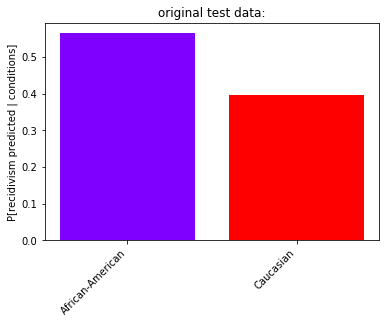

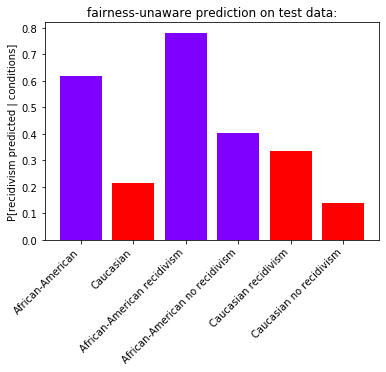

In [4]:
from sklearn.linear_model import LogisticRegression

unconstrained_predictor = LogisticRegression(class_weight='balanced')
unconstrained_predictor.fit(X_train, y_train)
    
# print and plot data from training and test set as well as predictions with fairness-unaware classifier on both sets 
# show only test data related plots by default - uncomment the next two lines to see training data plots as well
# show_proportions(X_train, sensitive_features_train, y_train, description="original training data:", plot_row_index=1)
# show_proportions(X_train, sensitive_features_train, unconstrained_predictor.predict(X_train), y_train, description="fairness-unaware prediction on training data:", plot_row_index=2)
show_proportions(X_test, sensitive_features_test, y_test, dataset_used, description="original test data:", plot_row_index=3)
show_proportions(X_test, sensitive_features_test, unconstrained_predictor.predict(X_test), dataset_used, y_test, description="fairness-unaware prediction on test data:", plot_row_index=4)
plt.show()

### Export Fairness-Unaware Dataframe for Future Comparison
We export the fairness unaware results to compare later.

In [5]:
fairness_unaware_df = X_test.copy()
fairness_unaware_df['predictions'] = unconstrained_predictor.predict(X_test)

if(dataset_used == 'adult'):
    fairness_unaware_df['Income Binary'] = y_test
elif(dataset_used == 'compas'):
    fairness_unaware_df['two_year_recid'] = y_test

if(dataset_used == 'adult'):
    fairness_unaware_df.to_csv('./../../predicted_data/unfair_logreg_adult.csv')
if(dataset_used == 'compas'):
    fairness_unaware_df.to_csv('./../../predicted_data/unfair_logreg_compas.csv')

In [6]:
from joblib import dump, load
if(dataset_used == 'adult'):
    dump(unconstrained_predictor, './../../predicted_data/unfair_models/unfair_logreg_adult.joblib')
if(dataset_used == 'compas'):
    dump(unconstrained_predictor, './../../predicted_data/unfair_models/unfair_logreg_compas.joblib')

# Postprocessing the model to get a fair model

The idea behind postprocessing is to alter the output of the fairness-unaware model to achieve fairness. The postprocessing algorithm requires three input arguments:
- the matrix of samples X
- the vector of predictions y from the fairness-unaware model 
- the vector of group attribute values A (in the code we refer to it as `sensitive_features`)

The goal is to make the output fair with respect to constraints. The postprocessing algorithm uses one of
- Demographic Parity (DP): $P\ [\ h(X)=\hat{y}\ |\ A=a] = P\ [\ h(X)=\hat{y}\ ] \qquad \forall a, \hat{y}$
- Equalized Odds (EO): $P\ [\ h(X)=\hat{y}\ |\ A=a, Y=y] = P\ [\ h(X)=\hat{y}\ |\ Y=y\ ] \qquad \forall a, \hat{y}$

where $h(X)$ is the prediction based on the input $X$, $\hat{y}$ and $y$ are labels, and $a$ is a sensitive feature value. In this example, we'd expect the postprocessed model with DP to be balanced between races. In this particular scenario it makes more sense to aim at fairness through accuracy like EO. EO does not make the same guarantees. Instead, it ensures parity between the subgroups of each race with label 1 in the training set, and parity between the subgroups of each race with label 0 in the training set. Applied to this scenario, this means that the subgroups of each race who reoffended in the past are equally likely to be predicted to reoffend (and therefore also equally likely not to). Similarly, there is parity between subgroups of each race without recidivism, but we have no parity between the groups with different training labels. In mathematical terms at the example of African-American and Caucasian:

$$
P\ [\ \text{recidivism predicted}\ |\ \text{African-American, recidivism}\ ] = P\ [\ \text{recidivism predicted}\ |\ \text{Caucasian, recidivism}\ ], \text{e.g. } 0.95\\
P\ [\ \text{recidivism predicted}\ |\ \text{African-American, no recidivism}\ ] = P\ [\ \text{recidivism predicted}\ |\ \text{Caucasian, no recidivism}\ ], \text{e.g. } 0.15
$$

but that also means that African-Americans (and Caucasians) of different subgroup based on training labels don't necessarily have parity:

$$
P[\text{recidivism predicted} | \text{African-American, recidivism}] = 0.95 \neq 0.15 = P[\text{recidivism predicted} | \text{African-American, no recidivism}]
$$

Assessing which disparity metric is indeed fair varies by application scenario. In this case the evaluation focuses on Equalized Odds, because the recidivism prediction should be accurate for each race, and for each subgroup within. The plot for the training data shows the intended outcome, while the plot for the test data exhibits slight variation which is likely due to randomized predictions as well as a slightly different data distribution.

In [7]:
# This wrapper around the unconstrained estimator serves the purpose of mapping the predict
# method to predict_proba so that we can use real values to get more accurate estimates.
class LogisticRegressionAsRegression:
    def __init__(self, logistic_regression_estimator):
        self.logistic_regression_estimator = logistic_regression_estimator
    
    def fit(self, X, y):
        self.logistic_regression_estimator.fit(X, y)
    
    def predict(self, X):
        # use predict_proba to get real values instead of 0/1, select only prob for 1
        scores = self.logistic_regression_estimator.predict_proba(X)[:,1]
        return scores


equalized odds with postprocessed model on test data:
P[recidivism predicted | African-American]                = 0.49382716049382713
P[recidivism predicted | African-American, recidivism]    = 0.6120218579234973
P[recidivism predicted | African-American, no recidivism] = 0.3404255319148936
P[recidivism predicted | Caucasian]                       = 0.4166666666666667
P[recidivism predicted | Caucasian, recidivism]           = 0.5555555555555556
P[recidivism predicted | Caucasian, no recidivism]        = 0.3252032520325203


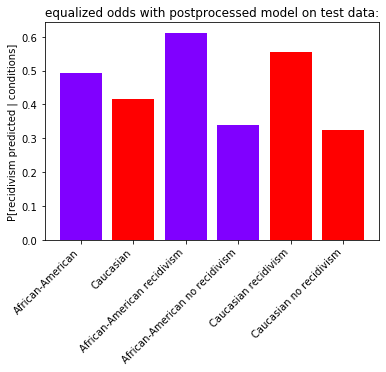

In [8]:
from fairlearn.postprocessing import ThresholdOptimizer
from copy import deepcopy

constraint_used = 'eo' # dp, eo
constraint_name = ''
if(constraint_used == 'dp'):
    constraint_name = 'demographic_parity'
elif(constraint_used == 'eo'):
    constraint_name = 'equalized_odds'

unconstrained_predictor_wrapper = LogisticRegressionAsRegression(unconstrained_predictor)
postprocessed_predictor = ThresholdOptimizer(
    unconstrained_predictor=unconstrained_predictor_wrapper,
    constraints=constraint_name)

postprocessed_predictor.fit(X_train, y_train, sensitive_features=sensitive_features_train)

fairness_aware_predictions_train = postprocessed_predictor.predict(X_train, sensitive_features=sensitive_features_train)
fairness_aware_predictions_test = postprocessed_predictor.predict(X_test, sensitive_features=sensitive_features_test)

# show only test data related plot by default - uncomment the next line to see training data plot as well
# show_proportions(X_train, sensitive_features_train, fairness_aware_predictions_EO_train, y_train, description="equalized odds with postprocessed model on training data:", plot_row_index=1)
show_proportions(X_test, sensitive_features_test, fairness_aware_predictions_test, dataset_used, y_test, description="equalized odds with postprocessed model on test data:", plot_row_index=2)
plt.show()

In [12]:
from sklearn.metrics import accuracy_score
# Accuracy
accuracy_score(fairness_aware_predictions_test, y_test)

0.6306818181818182

# Export Predicted DF

In [9]:
assert(len(X_test) == len(fairness_aware_predictions_test))
X_test['predictions'] = fairness_aware_predictions_test

if(dataset_used == 'adult'):
    X_test['Income Binary'] = y_test
elif(dataset_used == 'compas'):
    X_test['two_year_recid'] = y_test
    
X_test.head(5)
X_test.to_csv('./../../predicted_data/postprocessing/postprocessing_logreg_{}_{}.csv'.format(
    dataset_used, constraint_used))

## Export Model

In [10]:
from joblib import dump, load
if(dataset_used == 'adult'):
    dump(postprocessed_predictor, './../../predicted_data/fair_models/postprocessing_logreg_adult.joblib')
if(dataset_used == 'compas'):
    dump(postprocessed_predictor, './../../predicted_data/fair_models/postprocessing_logreg_compas.joblib')